In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from quetzal.model import stepmodel
from quetzal.analysis import analysis
from quetzal.engine.pathfinder import PublicPathFinder
from quetzal.io.display import all_pt_paths
from syspy.skims import skims

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the PT network
## Needs aggregated PT networks

In [2]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
ae = stepmodel.read_json(model_path + 'de_pt_access_egress')
aux = stepmodel.read_json(model_path + 'de_pt_network_ancillary')

In [4]:
sm.centroids = ae.centroids
sm.footpaths = ae.footpaths
sm.zone_to_transit = ae.zone_to_transit

In [5]:
sm.links.shape

(351366, 8)

### Prepare links for pathfinder

In [6]:
# aggregate local bus and tram, underground, ferry, funicular
if 'subway' in sm.links['route_type'].unique():
    sm.links['route_type_disagg'] = sm.links['route_type']
    sm.links['route_type'] = sm.links['route_type'].replace(
        {'tram': 'bus', 'subway': 'bus', 'ferry': 'bus', 'funicular': 'bus'})
    sm.pt_route_types = list(sm.links['route_type'].unique())

In [7]:
# Generate headways (two times the waiting time at a stop when changing between trips)
# ASSUMPTION: Take average headways for core hours between 6 a.m. and 8 p.m.
hours = set(range(6, 20))
def n_trips(g):
    hour_list = list(g)[0]
    return sum([hour_list.count(h) for h in set(hour_list).intersection(hours)])
freq = aux.frequencies.groupby(['stop_id', 'route_id']).agg({'hour': n_trips})
freq['hour'] = 14*3600 / freq['hour'] # 14 hours

In [8]:
headway_dict = freq['hour'].to_dict()
sm.links['headway'] = [headway_dict[(node, ind)]
                       if (node, ind) in headway_dict.keys() else np.nan
                       for ind, node in sm.links.set_index('route_id')['a'].items()]

array([<AxesSubplot:title={'center':'a'}, xlabel='route_type'>],
      dtype=object)

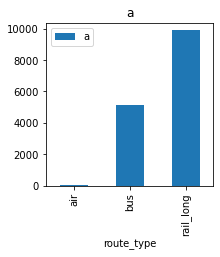

In [9]:
# Route types without headway
sm.links.loc[sm.links['headway'].isna()].groupby('route_type').agg(
    {'a': 'count'}).plot.bar(subplots=True, figsize=(3,3))

In [11]:
sm.links['headway'] = sm.links['headway'].fillna(2*3600)

In [12]:
# ASSUMPTION: Air trips require security checks and so on...
sm.links.loc[sm.links['route_type']=='air', 'headway'] = 45*60*2

In [13]:
# ASSUMPTION: Long-distance rail and coach trips are timed well
# and have maximum waiting times of 20 minutes
sm.links.loc[sm.links['route_type'].isin(['rail_long', 'coach']), 'headway'] = \
    sm.links.loc[sm.links['route_type'].isin(['rail_long', 'coach']),
                 'headway'].clip(lower=10*60*2, upper=30*60*2)

In [14]:
# ASSUMPTION: Maximum waiting time is 60 minutes, minumum is 3 minutes
sm.links['headway'] = sm.links['headway'].clip(lower=3*60*2, upper=60*60*2)

In [15]:
sm.links['headway'] = sm.links['headway'].astype(int)

<AxesSubplot:>

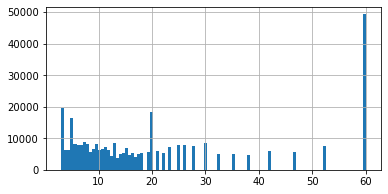

In [16]:
# Waiting time distribution in minutes
(sm.links['headway']/60/2).hist(bins=100, figsize=(6,3), log=False)

In [17]:
sm.links['headway'].mean()/60/2

22.603657771858025

In [18]:
# Set a mode-specific transfer penalty
# It will be substracted later
time_dict = {'bus': 0,
             'rail_short': 10,
             'rail_long': 30,
             'coach': 60,
             'air': 60}
sm.links['boarding_time'] = sm.links['route_type'].map(time_dict)*60 # in s

In [19]:
# Generate length for PT links
if 'length' not in sm.links.columns:
    sm.links['length'] = skims.distance_from_geometry(sm.links['geometry']).astype(int)
    # Adjust coach transport towards road distances
    sm.links.loc[sm.links['route_type']=='coach', 'length'] *= 1.136

In [20]:
sm.links.sample()

,route_type,geometry,a,b,link_sequence,route_id,time,trip_id,route_type_disagg,headway,boarding_time,length
index,,,,,,,,,,,,
r_s_114447,rail_short,"LINESTRING (13.28477 52.35067, 13.27196 52.31556)",r_s_n_978,r_s_n_13596,6,rail_short_74,240,rail_short_28297,rail_short,2400,600,4000


In [21]:
# Delete footpaths between centroids as they might confuse the pathfinder
# Add them later anew
sm.footpaths = sm.footpaths.loc[~((sm.footpaths['a'].isin(sm.centroids.index)) |
                                  (sm.footpaths['b'].isin(sm.centroids.index)) |
                                  (sm.footpaths['a']==sm.footpaths['b']))]

### Apply PT pathfinder
It generates the LoS table with shortest paths for each origin destination pair

In [ ]:
'''sm.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=True, # Allow different mode combinations
    route_column='route_id',
    mode_column='route_type',
    boarding_time=0, # Assumption
    alighting_time=0,
    speedup=True,
    walk_on_road=False,
    keep_pathfinder=False, # Saves it as attribute for multiple iterations
    force=False, # If indices are inconsistent
    path_analysis=True, # Create path, time and length columns
    drop_duplicates=True, # Considering duplicate paths
    cutoff=np.inf, # distance limit between points for Dijkstra algorithm
    od_set=od_set) # Exclude OD pairs that are not used'''
print('This cell would run all possible mode combinations')

In [22]:
# We don't want the algorithm to search paths for all mode combinations.
# Thus, we have to extract the pathfinder and search them manually.
ppf = PublicPathFinder(sm)

In [23]:
# Now, build custom mode combinations
# People just don't go by coach and then switch to rail or airplane within Germany
ppf.build_mode_combinations(mode_column='route_type')
ppf.mode_combinations = [x for x in ppf.mode_combinations
                         if not ('coach' in x and
                         ('rail_long' in x or
                          'rail_short' in x or
                          'air' in x))]
ppf.mode_combinations

[{'air', 'bus', 'rail_long', 'rail_short'},
 {'air', 'bus', 'rail_long'},
 {'air', 'bus', 'rail_short'},
 {'air', 'bus'},
 {'air', 'rail_long', 'rail_short'},
 {'air', 'rail_long'},
 {'air', 'rail_short'},
 {'air'},
 {'bus', 'coach'},
 {'bus', 'rail_long', 'rail_short'},
 {'bus', 'rail_long'},
 {'bus', 'rail_short'},
 {'bus'},
 {'coach'},
 {'rail_long', 'rail_short'},
 {'rail_long'},
 {'rail_short'},
 set()]

In [24]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_json(model_path + 'de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

Generated OD set with 160801 pairs


In [25]:
# Run the pathfinder for all mode combinations
# If there is no boarding time column in links table:
# Include a transfer penalty in order to promote direct routes.
# It will be substracted later
# The penalty must be None, if a link boarding time is set
transfer_penalty = None
ppf.find_broken_mode_paths(workers=3, # CPU cores
                           cutoff=np.inf,
                           od_set=od_set,
                           mode_column='route_type',
                           boarding_time=transfer_penalty)

breaking modes: set() : 100%|█████████████████████████████████████████████████████████| 18/18 [38:01<00:00, 126.77s/it]


In [26]:
ppf.broken_mode_paths.sample()

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes
10262,DE131,DE94E,24883.392838,"[DE131, coach_n_FLIXBUS:8, r_l_n_1243, r_l_543...",False,mode_breaker,"{air, bus}"


In [27]:
# Run the path analysis and assign paths as LoS table
sm.pt_los = analysis.path_analysis_od_matrix(
    od_matrix=ppf.broken_mode_paths,
    links=sm.links,
    nodes=sm.nodes,
    centroids=sm.centroids)

path_analysis: 100%|██████████████████████████████████████████████████████| 2493250/2493250 [02:43<00:00, 15236.74it/s]


In [28]:
print(len(sm.pt_los.index))
sm.pt_los.loc[sm.pt_los['origin']!=sm.pt_los['destination']].sample(3)

2493250


,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,link_path,footpaths,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path
72938,DE731,DEE09,19171.994207,"[DE731, r_s_n_1743, r_l_n_330, coach_n_FLIXBUS...",False,mode_breaker,"{air, rail_long, rail_short}",[coach_n_FLIXBUS:401],[coach_n_FLIXBUS:1184],"[r_s_n_1743, coach_n_FLIXBUS:401, coach_n_FLIX...","[coach_5355, coach_5356, coach_5357, coach_535...",[],"[(DE731, r_s_n_1743), (coach_n_FLIXBUS:1184, D...",[],[coach_5355],[coach_5361],False,0,13200,132781
88606,DE938,DEG0A,22596.614761,"[DE938, r_s_n_11358, r_s_73992, r_s_73993, r_s...",False,mode_breaker,{air},"[r_s_n_11358, r_s_n_1580, bus_n_278948]","[r_s_n_2519, r_s_n_12700, bus_n_391083]","[r_s_n_11358, r_s_n_2519, r_s_n_1580, r_s_n_12...","[r_s_73992, r_s_73993, r_s_73994, r_s_73995, r...","[(r_s_n_12700, bus_n_156782), (bus_n_156782, r...","[(DE938, r_s_n_11358), (bus_n_391083, DEG0A)]",[],"[r_s_73992, r_l_5892, r_s_27209, bus_284641]","[r_s_73995, r_l_5893, r_s_27211, bus_284652]",False,3,9360,220220
8961,DE12A,DE27E,19680.433973,"[DE12A, r_s_n_12507, r_s_19346, r_s_19347, r_s...",False,mode_breaker,{bus},"[r_s_n_12507, r_s_n_13421, r_s_n_5724]","[r_s_n_4815, r_s_n_1834, r_s_n_14075]","[r_s_n_12507, r_s_n_4815, bus_n_301465, r_s_n_...","[r_s_19346, r_s_19347, r_s_19348, r_s_19349, r...","[(r_s_n_4815, bus_n_301465), (bus_n_301465, r_...","[(DE12A, r_s_n_12507), (r_s_n_14075, DE27E)]",[],"[r_s_19346, r_s_103013, r_l_3586, r_s_170284]","[r_s_19349, r_s_103015, r_l_3586, r_s_170287]",False,3,8580,197644


### Add attributes to LoS table

In [29]:
# Add distances
len_dict = sm.links['length'].to_dict()
sm.pt_los['length'] = sm.pt_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [30]:
# Disaggregate time into in-vehicle and access/egress
# Substract the transfer penalty set above (put 0)
if transfer_penalty is None:
    sm.analysis_pt_time(boarding_time=None)
    sm.pt_los['time'] -= sm.pt_los['boarding_time']
#    sm.pt_los['boarding_time'] = 0
else:
    sm.analysis_pt_time(boarding_time=0)
print(sm.pt_los.columns)

Index(['origin', 'destination', 'gtime', 'path', 'reversed',
       'pathfinder_session', 'broken_modes', 'boardings', 'alightings',
       'node_path', 'link_path', 'footpaths', 'ntlegs', 'transfers',
       'boarding_links', 'alighting_links', 'all_walk', 'ntransfers',
       'time_link_path', 'length_link_path', 'length', 'access_time',
       'footpath_time', 'in_vehicle_time', 'waiting_time', 'boarding_time',
       'time'],
      dtype='object')


In [31]:
# Check times
sm.pt_los[['ntransfers', 'length']+[c for c in sm.pt_los.columns if c[-4:]=='time']].sample(2)

,ntransfers,length,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
40172,1,192010,18247.443628,2773.739881,288.996527,8481,4800.0,1800,16343.736408
78431,2,236320,17335.274238,2924.638813,77.988080,7920,3300.0,3000,14222.626893


In [32]:
# Add route_types
type_dict = sm.links['route_type'].to_dict()
sm.pt_los['route_types'] = [set([type_dict[link] for link in l])
                            for l in list(sm.pt_los['link_path'])]

In [33]:
# Add main route_type based on a hierarchy
hierarchy = ['air', 'coach', 'rail_long', 'rail_short', 'bus', 'walk']
def main_type(types):
    t = hierarchy[-1]
    try:
        t = hierarchy[min([hierarchy.index(t) for t in types])]
    except ValueError: # empty types set
        pass
    return t
sm.pt_los['route_type'] = sm.pt_los['route_types'].apply(main_type)

In [34]:
# Add price, parametrisation comes later because
# our GTFS feeds come without fares
sm.pt_los['price'] = 0

In [35]:
sm.pt_los.sample()

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,...,length,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,route_types,route_type,price
26254,DE21M,DE804,33906.654032,"[DE21M, r_l_n_442, r_s_n_5122, r_s_70406, r_s_...",False,mode_breaker,"{air, bus}",[r_s_n_5122],[r_s_n_7263],"[r_s_n_5122, r_s_n_7263, coach_n_FLIXBUS:834]",...,773232,555.074243,0.0,23460,3545.0,4200,27560.074243,"{rail_long, rail_short}",rail_long,0


In [36]:
# Make a safety copy before restricting results
los = sm.pt_los.copy()

In [37]:
#sm.pt_los = los.copy()

### Clean PT LOS

In [38]:
# Drop duplicates
sm.pt_los['path'] = sm.pt_los['path'].apply(tuple)
sm.pt_los.drop_duplicates('path', inplace=True)
sm.pt_los.reset_index(drop=True, inplace=True)
sm.pt_los.shape

(1834707, 30)

In [39]:
# Berlin - Hamburg
all_pt_paths(sm, 'DE300', 'DE600', verbose=False, group_name='route_type')

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.54it/s]


In [40]:
# Look at Berlin - Hamburg times
sm.pt_los.loc[(sm.pt_los['origin']=='DE300')&(sm.pt_los['destination']=='DE600')][
    ['ntransfers', 'length', 'route_types', 'link_path']+[c for c in sm.pt_los.columns if c[-4:]=='time']]

,ntransfers,length,route_types,link_path,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
15831,0,243138,{coach},[coach_14401],17387.064122,2124.676031,262.388092,11100,300.0,3600,13787.064122
106373,0,275211,{rail_short},"[r_s_136084, r_s_136085, r_s_136086, r_s_13608...",16262.303522,2575.267143,247.036379,9240,3600.0,600,15662.303522
234174,0,253129,{rail_long},"[r_l_9, r_l_10]",12314.318580,3010.779478,115.725081,6060,1200.0,1800,10386.504560
331320,0,253129,{rail_long},"[r_l_9, r_l_10]",12314.318580,3010.779478,115.725081,6060,1200.0,1800,10386.504560
480085,0,243138,{coach},[coach_14334],17387.064122,2124.676031,262.388092,11100,300.0,3600,13787.064122
776110,0,253129,{rail_long},"[r_l_7252, r_l_7253]",12314.318580,3010.779478,115.725081,6060,1200.0,1800,10386.504560
911548,0,253129,{rail_long},"[r_l_9, r_l_10]",12314.318580,3010.779478,115.725081,6060,1200.0,1800,10386.504560
1030017,0,253129,{rail_long},"[r_l_7252, r_l_7253]",12314.318580,3010.779478,115.725081,6060,1200.0,1800,10386.504560
1248110,0,253129,{rail_long},"[r_l_4270, r_l_4271]",12314.318580,3010.779478,115.725081,6060,1200.0,1800,10386.504560
1296313,0,253129,{rail_long},"[r_l_4270, r_l_4271]",12314.318580,3010.779478,115.725081,6060,1200.0,1800,10386.504560


In [41]:
# Drop trips with coach-rail or coach-air combinations
sm.pt_los = sm.pt_los.loc[~sm.pt_los['route_types'].apply(
    lambda x: 'coach' in x and ('rail_long' in x or 'rail_short' in x or 'air' in x))]
sm.pt_los.shape

(1554156, 30)

In [42]:
'''# Drop trips with air interchange
sm.pt_los.drop(sm.pt_los.loc[(sm.pt_los['route_type']=='air') &
                             (sm.pt_los['link_path'].apply(
                                 lambda x: len([t for t in x if type_dict[t]=='air'])>1))
                            ].index, inplace=True)'''
sm.pt_los.shape

(1554156, 30)

In [43]:
# Drop unrealistically long trips
sm.pt_los = sm.pt_los.loc[sm.pt_los['in_vehicle_time']<10*3600]
sm.pt_los.shape

(1532625, 30)

array([<AxesSubplot:title={'center':'time'}>], dtype=object)

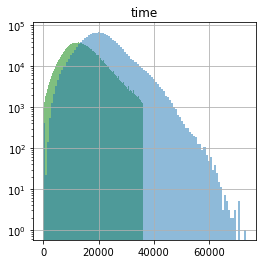

In [44]:
# Time distribution
sm.pt_los.hist(column='time', bins=100, log=True, alpha=.5,
               ax=sm.pt_los.hist(column='in_vehicle_time', color='green',
                                 bins=100, figsize=(4,4), log=True, alpha=.5))

array([[<AxesSubplot:title={'center':'ntransfers'}>]], dtype=object)

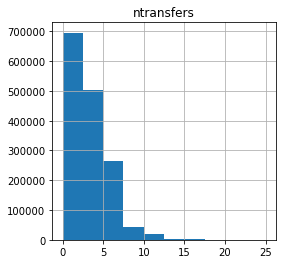

In [45]:
sm.pt_los.hist(column='ntransfers', figsize=(4,4))

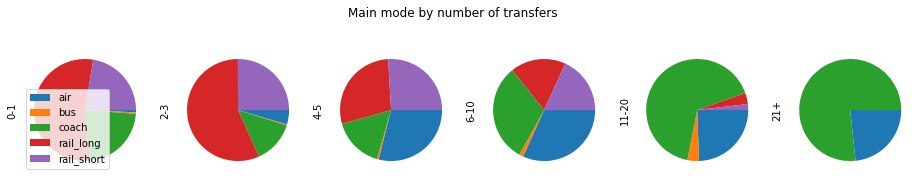

In [46]:
# Main mode distribution by transfers
t = sm.pt_los.copy()
t['bins'] = pd.cut(t['ntransfers'], bins=[0,1,3,5,10,20,100],
                   labels=["0-1", "2-3","4-5","6-10","11-20","21+"])
axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 3),
    startangle=0, counterclock=False, title='Main mode by number of transfers',
    legend=False, labeldistance=None)
axs[0].legend(loc='lower left')

<AxesSubplot:xlabel='route_types'>

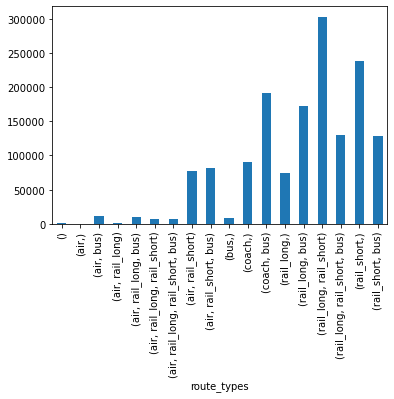

In [47]:
# Distribution of mode combinations
t['route_types'] = t['route_types'].apply(tuple)
t.groupby('route_types').count()['route_type'].plot(kind='bar')

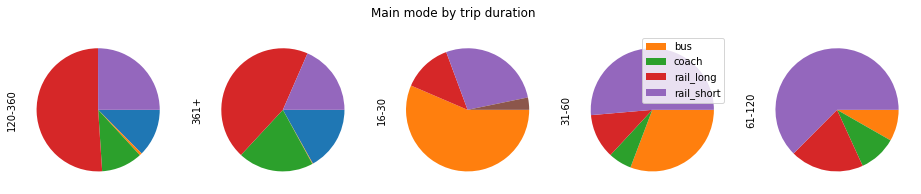

In [48]:
t['time'] = t['time'] / 60
t['bins'] = pd.cut(t['time'], bins=[0,15,30,60,120,360,500],
                   labels=["0-15", "16-30","31-60","61-120","120-360","361+"])
axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 3),
    startangle=0, counterclock=False, title='Main mode by trip duration',
    legend=False, labeldistance=None)
axs[3].legend()

In [49]:
t = None

In [50]:
# Drop unnecessary long connections if there is a waiting time applied
if sm.links['headway'].mean() > 1*60:
    sm.pt_los = sm.pt_los.loc[sm.pt_los['ntransfers']<=7]
    print(sm.pt_los.shape)
    # Drop coach connections with more than one transfer
    sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='coach') &
                                (sm.pt_los['boardings'].apply(
                                    lambda l: len([n for n in l if n.startswith('coach')])>2)
                                ))]
    print(sm.pt_los.shape)

(1465597, 30)
(1411424, 30)


In [51]:
# Keep only the fastest trip(s)
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple)
sm.pt_los = sm.pt_los.sort_values('time').groupby(
    ['origin', 'destination', 'route_types']).nth([0]).reset_index()
sm.pt_los.shape

(730111, 30)

In [52]:
# Bus tickets are relatively cheap, but they apply only for short distances
# And nobody books tickets at five different bus agencies
# Thus, drop bus trips longer than 100km
sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='bus') & (sm.pt_los['length']>100000))]
sm.pt_los.shape

(729309, 30)

<AxesSubplot:xlabel='route_types'>

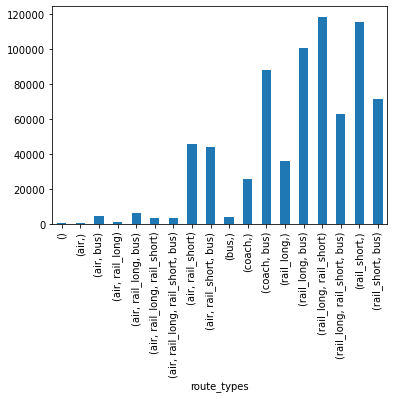

In [53]:
sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

array([<AxesSubplot:title={'center':'time'}>], dtype=object)

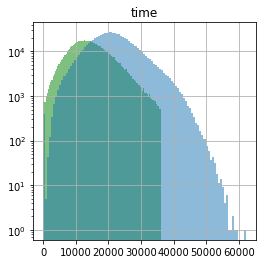

In [54]:
# Time distribution
sm.pt_los.hist(column='time', bins=100, log=True, alpha=.5,
               ax=sm.pt_los.hist(column='in_vehicle_time', color='green',
                                 bins=100, figsize=(4,4), log=True, alpha=.5))

In [55]:
# Look at Berlin - Hamburg times
sm.pt_los.loc[(sm.pt_los['origin']=='DE300')&(sm.pt_los['destination']=='DE600')][
    ['ntransfers', 'length', 'route_types', 'link_path']+[c for c in sm.pt_los.columns if c[-4:]=='time']]

,ntransfers,length,route_types,link_path,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
252588,0,243138,"(coach,)",[coach_14401],17387.064122,2124.676031,262.388092,11100,300.0,3600,13787.064122
252589,0,253129,"(rail_long,)","[r_l_1095, r_l_1096]",12314.318580,3010.779478,115.725081,6060,1200.0,1800,10386.504560
252590,0,275211,"(rail_short,)","[r_s_136084, r_s_136085, r_s_136086, r_s_13608...",16262.303522,2575.267143,247.036379,9240,3600.0,600,15662.303522


In [56]:
# Stuttgart and surrounding?
sm.pt_los.loc[(sm.pt_los['origin']=='DE112')&(sm.pt_los['destination']=='DE111')]

,origin,destination,route_types,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,...,length_link_path,length,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,route_type,price
2012,DE112,DE111,"(bus,)",4539.956525,"(DE112, coach_n_FLIXBUS:4278, r_s_n_7349, bus_...",False,mode_breaker,"{air, rail_long, rail_short}","[bus_n_222552, bus_n_301561, bus_n_310057]","[bus_n_4318, bus_n_310057, bus_n_145916]",...,11131,11131,2146.386458,474.570067,780,1139.0,0,4539.956525,bus,0
2013,DE112,DE111,"(coach,)",16096.386458,"(DE112, coach_n_FLIXBUS:4278, coach_1875, coac...",False,mode_breaker,"{air, rail_long, rail_short, bus}","[coach_n_FLIXBUS:4278, coach_n_FLIXBUS:8058]","[coach_n_FLIXBUS:8058, coach_n_FLIXBUS:17]",...,39321,39321,2146.386458,0.000000,4500,2250.0,7200,8896.386458,coach,0
2014,DE112,DE111,"(rail_long,)",7032.170052,"(DE112, coach_n_FLIXBUS:4278, r_l_n_601, r_l_6...",False,mode_breaker,"{air, rail_short, bus}",[],[],...,16857,16857,2577.510522,71.226490,1200,1200.0,1800,5048.737012,rail_long,0
2015,DE112,DE111,"(rail_short,)",4150.027729,"(DE112, coach_n_FLIXBUS:4278, r_l_n_1033, bus_...",False,mode_breaker,"{air, rail_long}",[r_s_n_2800],[r_s_n_13489],...,9427,9427,2146.386458,244.872469,540,475.0,600,3406.258927,rail_short,0


In [57]:
# Keep only trips where in-vehicle-time makes at least a third
#sm.pt_los = sm.pt_los.loc[sm.pt_los['time']<sm.pt_los['in_vehicle_time']*3]
#sm.pt_los.shape
len(sm.pt_los.loc[sm.pt_los['time']<sm.pt_los['in_vehicle_time']*3])

720074

In [58]:
sm.pt_los.loc[sm.pt_los.isna().any(axis=1)]

,origin,destination,route_types,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,...,length_link_path,length,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,route_type,price


### Save model

In [59]:
# Ditch unneccessary columns
to_drop = ['gtime', 'path', 'reversed', 'pathfinder_session',
           'broken_modes', 'boardings', 'alightings', 'node_path',
           'footpaths', 'ntlegs', 'transfers', 'boarding_links',
           'alighting_links', 'all_walk', 'time_link_path',
           'length_link_path', 'boarding_time', 'index']
sm.pt_los = sm.pt_los.drop(to_drop, axis=1, errors='ignore')

In [60]:
# Clean links table
to_drop = ['duration', 'cost', 'origin', 'destination']
sm.links = sm.links.drop(to_drop, axis=1, errors='ignore')

In [61]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'footpath_time',
        'waiting_time', 'length']
sm.pt_los[cols] = sm.pt_los[cols].astype(int)

In [62]:
sm.pt_los.sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,time,route_type,price
51565,DE134,DE21L,"(rail_long, bus)","[r_l_4382, r_l_4383, r_l_4384, r_l_4385, r_l_4...",3,348910,2268,434,12420,2601,17725,rail_long,0


In [63]:
# Saving LoS...
sm.to_json(model_path + 'de_pt_los', only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 35/35 [00:32<00:00,  1.07it/s]


In [66]:
'''# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['link_sequence', 'route_id', 'time', 'trip_id', 'length', 'headway']
if 'route_type_disagg' in sm.links.columns: cols.append('route_type_disagg')
if 'boarding_time' in sm.links.columns: cols.append('boarding_time')
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)
# Save PT network model
sm.to_json(model_path + 'de_pt_network_agg', only_attributes=[
    'zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + 'de_pt_network_agg/links_quetzaldata.json')'''
print('Not neccessary to save')

Not neccessary to save
